In [2]:
import logging
import pdb
import warnings
from pathlib import Path

import cartopy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# import metplotpy.contributed.fv3_physics_tend
import numpy as np
import pandas as pd
import xarray
from metpy.units import units
from utils import fmt, getfcst, getobs, tissot

warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

In [3]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path("/glade/derecho/scratch/ahijevyc/ks21_tmp")

# set extent
lon0 = -134
lon1 = -48
lat0 = 23
lat1 = 65


def subset_lonlat(df):
    df.loc[df["LON(E)"] >= 180, "LON(E)"] = df.loc[df["LON(E)"] >= 180, "LON(E)"] - 360
    lat = df["LAT(N)"]
    lon = df["LON(E)"]
    df = df[lat.between(lat0, lat1) & lon.between(lon0, lon1)]
    return df


isensemble = False
# Choose a forecast length (24, 48, 72, or 240 work for deterministic fcsts)
forecast_length = 192 if isensemble else 240

datepos = 0
F024 = sorted(casedir.glob(f"[12]?????????.F024.C768"))
if isensemble:
    assert forecast_length in [
        192,
        120,
    ], f"unexpected ensemble forecast_length {forecast_length}"
    F024 = sorted(casedir.glob(f"E[12]?????????.p??.F024.C768"))
    datepos = 1


itimes = pd.Series(
    [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in F024],
    name="initialization_time",
)

case_dates = itimes + pd.to_timedelta("24h")

print(f"found {len(case_dates)} cases in casedir {casedir}")

# Choose an initialization time index
# 10 in Lupo2023
case_index = 10
case = case_dates[case_index]

logging.info(f"chose case={case}")

pd.Series(case_dates, name="case")

found 24 cases in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


0    2019-10-26 06:00:00
1    2019-11-27 06:00:00
2    2019-12-23 00:00:00
3    2020-02-12 06:00:00
4    2020-02-23 12:00:00
5    2020-03-04 00:00:00
6    2020-04-09 12:00:00
7    2020-04-12 12:00:00
8    2020-05-19 12:00:00
9    2020-09-01 18:00:00
10   2020-09-10 00:00:00
11   2020-10-28 18:00:00
12   2020-11-28 06:00:00
13   2021-03-17 18:00:00
14   2021-04-12 00:00:00
15   2021-04-14 12:00:00
16   2021-05-01 06:00:00
17   2021-10-19 18:00:00
18   2021-10-29 06:00:00
19   2022-01-03 06:00:00
20   2022-02-16 12:00:00
21   2022-04-14 06:00:00
22   2022-05-05 12:00:00
23   2022-06-14 18:00:00
Name: case, dtype: datetime64[ns]

In [4]:
def assign_time(ds: xarray.Dataset):
    """convert Times variable to datetime and assign to coordinate
    same with initialization_time"""

    # remove one-element-long Time dimension
    # It has no value associated with it.
    ds = ds.squeeze(dim="Time", drop=True)

    logging.info("decode valid_time variable")
    fmt = "%Y-%m-%d_%H:%M:%S"
    valid_time = pd.to_datetime(
        ds["Times"].load().item().decode("utf-8").strip(),
        format=fmt,
    )

    # assign initialization time variable to its own coordinate
    ds = ds.assign_coords(
        valid_time=(
            ["valid_time"],
            [valid_time],
        ),
    )

    initialization_time = pd.to_datetime(ds.attrs["SIMULATION_START_DATE"], format=fmt)

    ds["fhr"] = (valid_time - initialization_time) / pd.to_timedelta("1h")

    ds = ds.expand_dims(initialization_time=[initialization_time])

    return ds

In [5]:
parallel = False
if parallel:
    try:
        client.cluster.close()
        client.shutdown()
        client.close()
    except:
        pass

    from dask.distributed import Client

    client = Client(n_workers=2)
    client

In [ ]:
ifiles = []
for lead_time in [24, 48, 72, 96]:
    initialization_time = case - lead_time * pd.to_timedelta("1h")
    forecast_length = lead_time if lead_time != 96 else 240
    FHR = f"F{forecast_length:03d}"
    gen = (casedir / f"{initialization_time.strftime('%Y%m%d%H')}.{FHR}.C768").glob(
        "interp/interp_fv3_history2d_*_f0??.nc"
    )  # ignore forecast hours over 96. with f0??
    ifiles.extend(list(gen))
ifiles = sorted(ifiles)

logging.warning(f"opening {len(ifiles)} files")
ds = xarray.open_mfdataset(
    ifiles,
    preprocess=assign_time,
    parallel=True,
    compat="override",
    coords="minimal",
    combine_attrs="drop_conflicts",
)
logging.warning(f"opened {len(ifiles)} files")
logging.info(ifiles)

# Take 1-d lat and 1-d lon coordinates from 2-d XLONG and XLAT
lon = ds.XLONG.isel(south_north=0).values
# lon = np.roll(np.arange(-180, 180, 0.25)+0.25, 360*2+1)
lat = ds.XLAT.isel(west_east=0).values
# lat = np.linspace(90, -90, 180*4+1)
assert all(np.diff(lat) < 0), "expected lat to decrease monotonically"
ds = ds.rename_dims(south_north="lat", west_east="lon").assign_coords(
    lon=("lon", lon), lat=("lat", lat)
)

In [22]:
ifiles

[PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f006.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f012.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f018.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f024.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f030.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f036.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f042.nc'),
 PosixPath('/glade/campaign/mmm/parc/mwong/ufs-mrw/2020090600.F240.C768/interp/interp_fv3_history2d_2020090600_f048.nc'),
 PosixPath('/glade/campa

In [13]:
# lat dimension goes from 90 to -90 so slice starts with larger latitude.
# set extent
lon0 = -179
lon1 = 50
lat0 = -83
lat1 = 80

ds = ds.sel(lat=slice(lat1, lat0), lon=slice(lon0, lon1))

# Group variables by common prefix, extract numeric vertical levels,
# then stack them and assign the vertical level as the coordinate.
potential_plevs = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50, 10]
STATEVARS = ["omg", "q", "rh", "t", "u", "v", "z"]
TENDS = {}
TENDS["t"] = [
    "cnvgwd",
    "deepcnv",
    "lw",
    "mp",
    "nonphys",
    "ogwd",
    "pbl",
    "rdamp",
    "shalcnv",
    "sw",
]
TENDS["q"] = [
    "deepcnv",
    "mp",
    "nonphys",
    "pbl",
    "shalcnv",
]
TENDS["u"] = [
    "cnvgwd",
    "deepcnv",
    "mp",
    "nonphys",
    "ogwd",
    "pbl",
    "rdamp",
    "shalcnv",
]
TENDS["v"] = TENDS["u"]

# `omg` `rh` and `z` have no tendency
TENDS["omg"] = TENDS["rh"] = TENDS["z"] = []

for statevar in STATEVARS:
    for tend in TENDS[statevar] + [""]:
        potentialvars = [f"d{statevar}3dt{plev}_{tend}" for plev in potential_plevs]
        newvar = f"d{statevar}3dt_{tend}"
        if tend == "":
            potentialvars = [f"{statevar}{plev}" for plev in potential_plevs]
            newvar = statevar
        logging.info(newvar)
        this_vars = [var for var in potentialvars if var in ds]
        if not this_vars:
            continue
        stack = []
        for var in this_vars:
            logging.info(f"{var} {statevar} {tend}")
            plev = int(
                var.removeprefix(f"d{statevar}3dt")
                .removeprefix(statevar)
                .removesuffix(f"_{tend}")
            )
            assert plev, f"unexpected plev {plev}"
            tmpvar = ds[var].expand_dims(pfull=[plev])
            tmpvar.attrs["description"] = tmpvar.attrs["description"].lstrip(f"{plev}-mb ")
            stack.append(tmpvar)
            ds = ds.drop_vars(var)
        ds[newvar] = xarray.concat(stack, dim="pfull")


ds

<xarray.Dataset> Size: 81GB
Dimensions:              (initialization_time: 4, valid_time: 16, lon: 713,
                          lat: 653, pfull: 14)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 32B 2020-09-06 ...
  * valid_time           (valid_time) datetime64[ns] 128B 2020-09-06T06:00:00...
  * lon                  (lon) float32 3kB -179.0 -178.8 -178.5 ... -1.25 -1.0
  * lat                  (lat) float32 3kB 80.0 79.75 79.5 ... -82.75 -83.0
  * pfull                (pfull) int64 112B 1000 925 850 700 ... 150 100 50 10
    XLONG                (lat, lon) float32 2MB dask.array<chunksize=(653, 713), meta=np.ndarray>
    XLAT                 (lat, lon) float32 2MB dask.array<chunksize=(653, 713), meta=np.ndarray>
Data variables: (12/189)
    Times                (valid_time, initialization_time) object 512B b'2020...
    us                   (valid_time, initialization_time, lat, lon) float32 119MB dask.array<chunksize=(1, 1, 653, 713), meta=np.ndarray>
    vs                   (valid_time, initialization_time, lat, lon) float32 119MB dask.array<chunksize=(1, 1, 653, 713), meta=np.ndarray>
    albdo_ave            (valid_time, initialization_time, lat, lon) float32 119MB dask.array<chunksize=(1, 1, 653, 713), meta=np.ndarray>
    cprat_ave            (valid_time, initialization_time, lat, lon) float32 119MB dask.array<chunksize=(1, 1, 653, 713), meta=np.ndarray>
    cpratb_ave           (valid_time, initialization_time, lat, lon) float32 119MB dask.array<chunksize=(1, 1, 653, 713), meta=np.ndarray>
    ...                   ...
    dv3dt_ogwd           (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 713), meta=np.ndarray>
    dv3dt_pbl            (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 713), meta=np.ndarray>
    dv3dt_rdamp          (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 713), meta=np.ndarray>
    dv3dt_shalcnv        (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 713), meta=np.ndarray>
    v                    (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 713), meta=np.ndarray>
    z                    (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 713), meta=np.ndarray>
Attributes: (12/16)
    WEST-EAST_GRID_DIMENSION:    1441
    SOUTH-NORTH_GRID_DIMENSION:  722
    BOTTOM-TOP_GRID_DIMENSION:   1
    SIMULATION_START_DATE:       2020-09-06_00:00:00
    START_DATE:                  2020-09-06_00:00:00
    DX:                          27794.369140625
    ...                          ...
    MOAD_CEN_LAT:                0.0
    STAND_LON:                   0.0
    POLE_LAT:                    90.0
    POLE_LON:                    0.0
    MAP_PROJ:                    6
    MAP_PROJ_CHAR:               Lat/Lon

In [9]:
def subtract_shift(da, n):
    # difference from n times earlier
    # Gets rid of first n times because there is no data to subtract from them.
    if n == 0:
        return da
    assert (
        n < da.valid_time.size
    ), f"n must be < number of Times {da.valid_time.size}"
    assert da.attrs, 'DataArray should have some attributes'
    da_attrs = da.attrs.copy()  # remember description and units
    da = da - da.shift(valid_time=n)
    dsec = (da.valid_time - da.valid_time.shift(valid_time=n)).dt.total_seconds()
    # Convert last element of dsec from seconds to hours
    dhour = dsec.item(-1)/3600
    da.attrs.update(da_attrs)
    if da.name not in STATEVARS:
        # You might think you need to multiply `da` by dsec, since the units of tendency in the 
        # netCDF file are blah/s. I don't think there should be a per second in the units.
        da.attrs["units"] = units(da.attrs["units"]) * units.second
    #varname = da_attrs["description"]
    da.attrs["long_name"] = f"{dhour:.0f}-h change"
    da.attrs["description"] = da.attrs["long_name"]
    return da

................

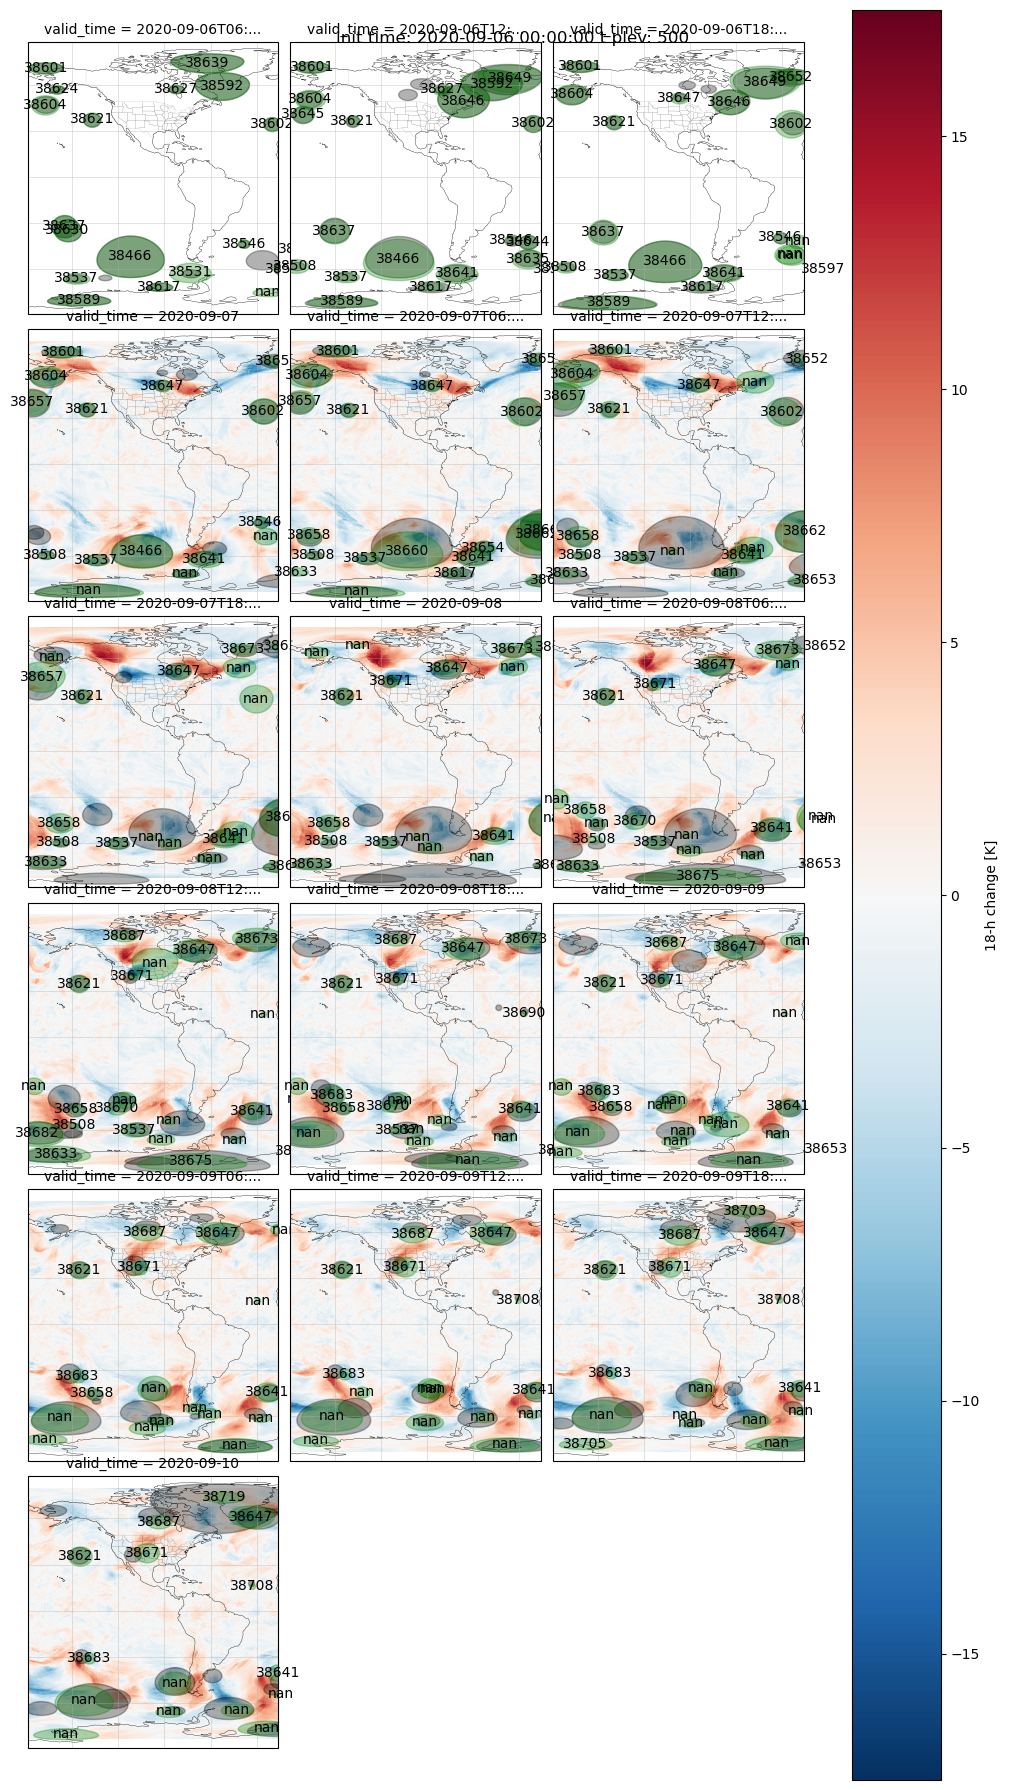

In [10]:
assert (ds.fhr.min(dim="valid_time") == 6).all(), f"first_valid time not fhr=6 {ds.fhr}"

# VARIABLE in all caps is supposed to be constant throughout script
INITIALIZATION_TIME = case - pd.to_timedelta("96h")
shiftTime = 3
var = "t"
plev = 500

da = (
    subtract_shift(ds[var]
    .sel(pfull=plev), shiftTime)
    .sel(
        initialization_time=INITIALIZATION_TIME,
        valid_time=slice(INITIALIZATION_TIME + pd.to_timedelta("6h"), case),
    )
)

projection = cartopy.crs.PlateCarree()
p = da.plot(
    row="valid_time",
    col_wrap=3,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)


for valid_time, ax in zip(da.valid_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.1, alpha=0.5)
    obs = getobs(valid_time)
    fcst = getfcst(INITIALIZATION_TIME, valid_time, workdir)

    fcst = subset_lonlat(fcst)
    obs = subset_lonlat(obs)

    for i, row in fcst.iterrows():
        lat = row["LAT(N)"]
        lon = row["LON(E)"]
        ax.text(
            lon,
            lat,
            f"{row.ID:.0f}",
            ha="center",
            va="center",
            transform=cartopy.crs.PlateCarree(),
        )
        # values = ds_pt[var].values
        # values[..., idx] = np.nan # blank out blob data for debugging
        # ds_pt[var] = xarray.DataArray(values, coords=ds_pt[var].coords)

    tissot(ax, obs, alpha=0.3, color="k")
    alpha = 0.3
    tissot(ax, fcst, alpha=alpha, color="green")
    ax.set_extent((lon0, lon1 - 15, lat0, lat1 - 6))
    ax.gridlines(lw=0.5, alpha=0.5)

#ds_pt = ds_pt.unstack()
s = p.fig.suptitle(f"init time: {INITIALIZATION_TIME} {var} plev: {plev}")

....

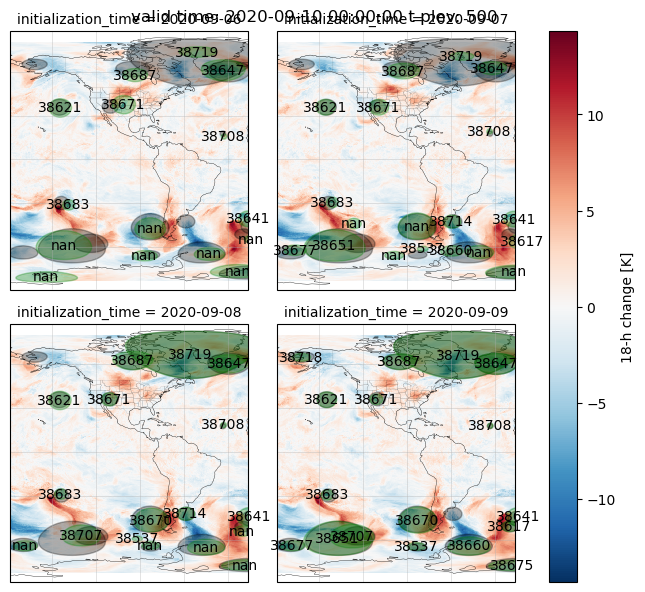

In [11]:
da = subtract_shift(ds[var].sel(pfull=plev), shiftTime).sel(valid_time=case)

projection = cartopy.crs.PlateCarree()
p = da.plot(
    row="initialization_time",
    col_wrap=2,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)

obs = getobs(case)
obs = subset_lonlat(obs)
for initialization_time, ax in zip(da.initialization_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.1, alpha=0.5)
    fcst = getfcst(initialization_time, case, workdir)
    fcst = subset_lonlat(fcst)

    for i, row in fcst.iterrows():
        lat = row["LAT(N)"]
        lon = row["LON(E)"]
        ax.text(
            lon,
            lat,
            f"{row.ID:.0f}",
            ha="center",
            va="center",
            transform=cartopy.crs.PlateCarree(),
        )

    tissot(ax, obs, alpha=0.3, color="k")
    alpha = 0.3
    tissot(ax, fcst, alpha=alpha, color="green")
    ax.set_extent((lon0, lon1 - 15, lat0, lat1 - 6))
    ax.gridlines(lw=0.5, alpha=0.5)

p.set_titles(template="{coord} = {value}", maxchar=300)
s = p.fig.suptitle(f"valid time: {case} {var} plev: {plev}")

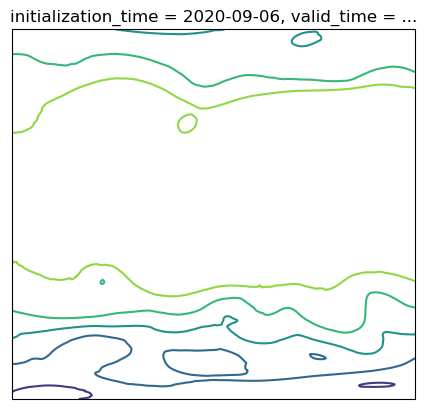

In [21]:
ds.z.sel(
    pfull=plev, initialization_time=INITIALIZATION_TIME, valid_time=valid_time
).plot.contour(
    linestyle="dashed",
    label="forecast",
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
    color="k",
)
g.axs.clabel

.2020-09-06T06:00:00.000000000 obs empty
.2020-09-06T12:00:00.000000000 obs empty
.2020-09-06T18:00:00.000000000 obs empty
.2020-09-07T00:00:00.000000000 obs empty
.2020-09-07T06:00:00.000000000 obs empty
.2020-09-07T12:00:00.000000000 obs empty
.2020-09-07T18:00:00.000000000 fcst empty
.........t.f240.3.png


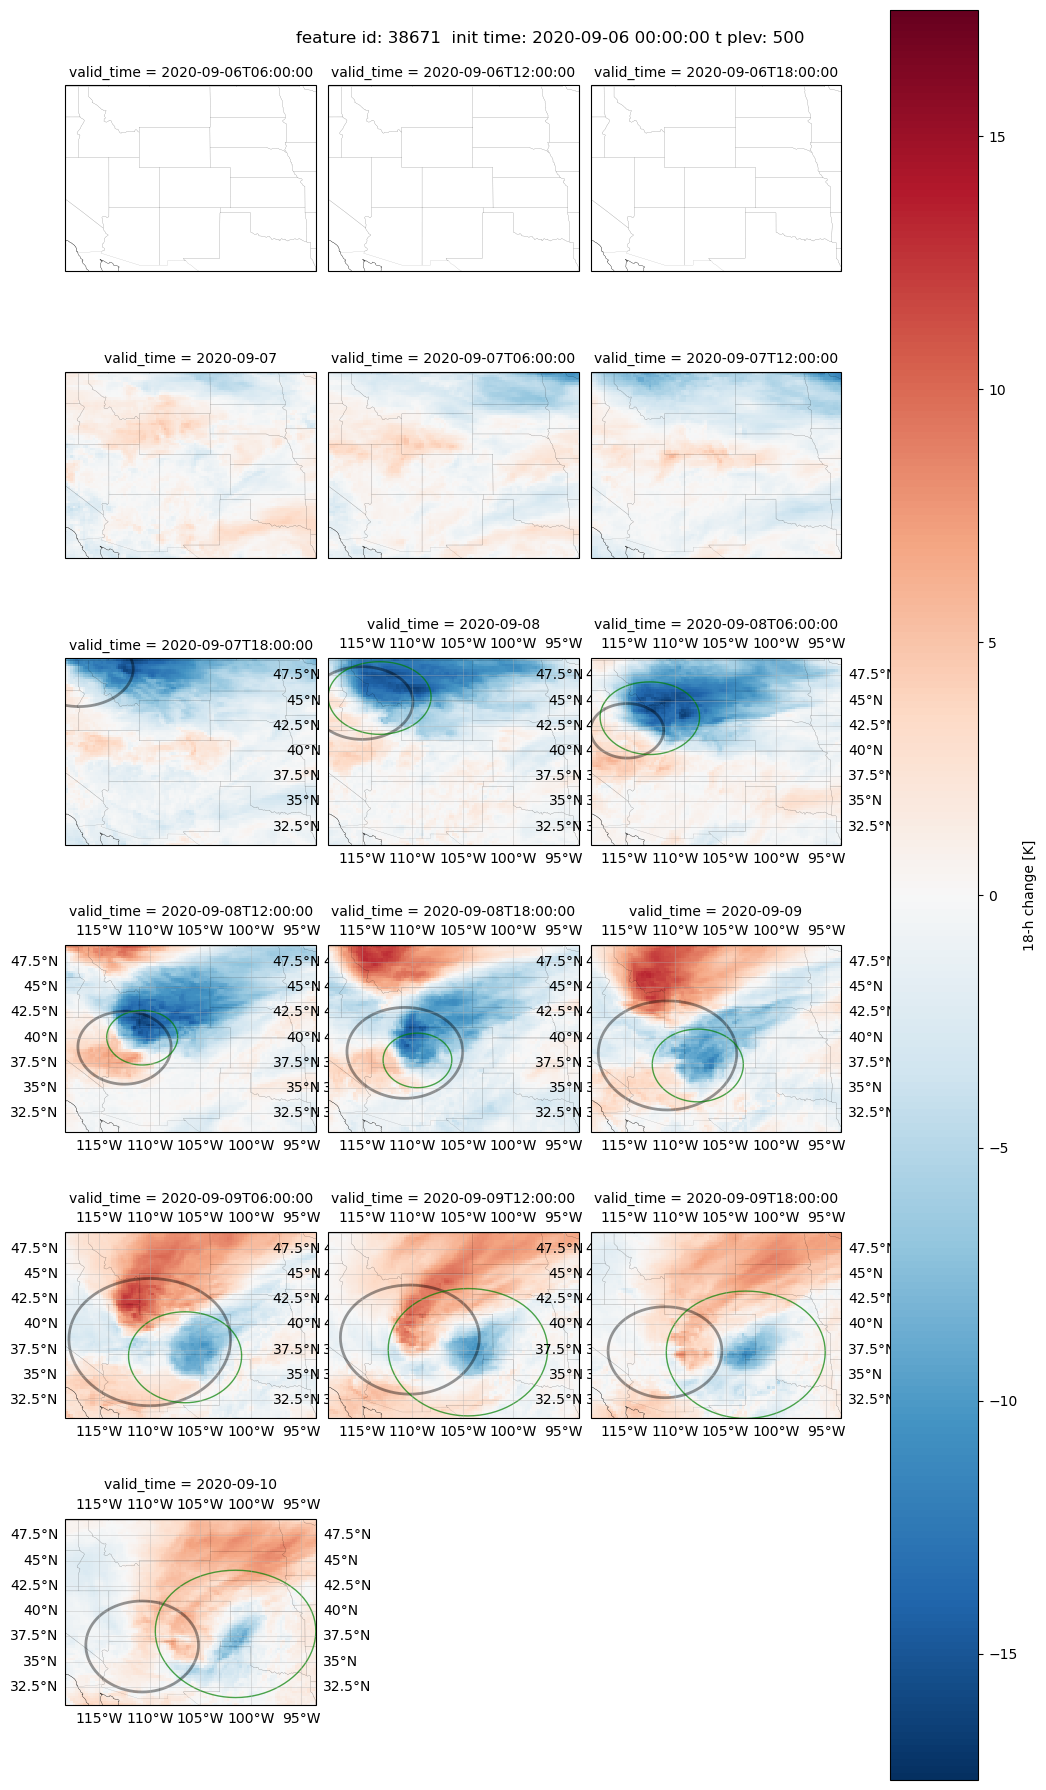

In [17]:
id = 38671

da = subtract_shift(ds[var].sel(pfull=plev), shiftTime).sel(
    initialization_time=INITIALIZATION_TIME,
    valid_time=slice(INITIALIZATION_TIME + pd.to_timedelta("6h"), case),
)

p = da.plot(
    row="valid_time",
    col_wrap=3,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)

minlon = np.inf
maxlon = -np.inf
minlat = np.inf
maxlat = -np.inf
for valid_time, ax in zip(da.valid_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.1, alpha=0.5)
    ax.plot(
        ds.z.sel(pfull=plev, initialization_time=INITIALIZATION_TIME, valid_time=valid_time),
        linestyle="dashed",
        label="forecast",
        transform=cartopy.crs.PlateCarree()
    )

    obs = getobs(valid_time)
    fcst = getfcst(INITIALIZATION_TIME, valid_time, workdir)
    obs = obs[(obs.ID == id)]
    obs = subset_lonlat(obs)
    if obs.empty:
        print(f"{valid_time.data} obs empty")
        continue
    tissot(ax, obs, alpha=0.4, facecolor="none", lw=2)

    fcst = subset_lonlat(fcst)
    fcst = fcst[(fcst.ID == id)]
    lat = fcst["LAT(N)"].values
    lon = fcst["LON(E)"].values
    if fcst.empty:
        print(f"{valid_time.data} fcst empty")
        continue

    alpha = 0.7
    t = tissot(ax, fcst, alpha=alpha, color="green", facecolor="none")
    kmPerLon = 111.1 * np.cos(np.deg2rad(lat))
    (dlon,) = fcst["Ro(km)"].values / kmPerLon
    dlat = fcst["Ro(km)"].values / 111.1
    if lon - dlon < minlon:
        minlon = lon - dlon
    if lon + dlon > maxlon:
        maxlon = lon + dlon
    if lat - dlat < minlat:
        minlat = lat - dlat
    if lat + dlat > maxlat:
        maxlat = lat + dlat

    gl = ax.gridlines(lw=0.5, alpha=0.5, draw_labels=True)


ax.set_extent((minlon, maxlon, minlat, maxlat))
s = p.fig.suptitle(f"feature id: {id}  init time: {INITIALIZATION_TIME} {var} plev: {plev}")
ofile = f"{var}.f{forecast_length:03d}.{shiftTime}.png"
p.set_titles(template="{coord} = {value}", maxchar=300)
p.fig.savefig(ofile)
print(ofile)

In [15]:
from typing import Tuple, Union


def vlines(ax, df, zonal: bool, **kwargs) -> None:
    if df.empty:
        return
    lat0 = df["LAT(N)"].values[0]
    lon0 = df["LON(E)"].values[0] - 360
    km_per_deg_lon = 111.1 * np.cos(np.deg2rad(lat0))
    dlat = df["Ro(km)"].values[0] / 111.1
    dlon = df["Ro(km)"].values[0] / km_per_deg_lon
    if zonal:
        x, dx = lon0, dlon
    else:
        x, dx = lat0, dlat
    # Plot vertical lines at the edges of obs feature
    ax.axvline(x=x - dx, **kwargs)
    ax.axvline(x=x + dx, **kwargs)
    return


def feature_xs(
    da: xarray.DataArray,
    feature_id: Union[int, str],
    loopdim: str,
    ncols: int = 2,
    zonal: bool = True,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plots a vertical cross section of an xarray DataArray, with options to
    slice zonally or meridionally, over a time loop.

    Args:
        da (xarray.DataArray): The data array to plot.
        feature_id (Union[int, str]): Feature ID to locate specific data.
        loopdim (str): The dimension name to loop over (e.g., "initialization_time").
        ncols (int, optional): Number of columns in the subplot grid. Defaults to 3.
        zonal (bool, optional): If True, plots zonally. Otherwise, plots meridionally. Defaults to True.

    Returns:
        Tuple[plt.Figure, np.ndarray]: The figure and array of axes.
    """

    # Calculate the number of rows based on the size of loopdim
    nrows = int(np.ceil(da[loopdim].size / ncols))

    # Initialize subplots
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(12, nrows * 2),
    )

    # Cache repeated attribute access outside the loop for efficiency
    valid_time_attr = da.valid_time
    initialization_time_attr = da.initialization_time

    # Loop over each time step in the loop dimension
    for this_time, ax in zip(da[loopdim], axes.flat):
        if loopdim == "initialization_time":
            initialization_time = this_time
            valid_time = valid_time_attr
        else:
            initialization_time = initialization_time_attr
            valid_time = this_time

        # Fetch observational and forecast data
        obs = getobs(valid_time)
        # Filter the data for the feature_id
        obs = obs[obs.ID == feature_id]

        vlines(ax, obs, zonal, color="k", alpha=0.4, lw=2)

        fcst = getfcst(initialization_time, valid_time, workdir)
        # Extract feature_id
        feature_data = fcst[fcst.ID == feature_id]
        if feature_data.empty:
            continue

        vlines(ax, feature_data, zonal, color="green", alpha=0.7)

        # Center on forecast feature
        lat0 = feature_data["LAT(N)"].values[0]
        lon0 = feature_data["LON(E)"].values[0] - 360
        if zonal:
            x = "lon"
            lon = slice(lon0 - 20, lon0 + 20)
            lat = lat0
            xlim = (lon.start, lon.stop)
        else:
            x = "lat"
            lon = lon0
            lat = slice(lat0 + 15, lat0 - 15)
            xlim = (lat.start, lat.stop)

        # Select the cross section
        xs = da.sel(
            {
                loopdim: this_time,
                "lat": lat,
                "lon": lon,
            }
        )

        # Plot the main data
        p = xs.plot(
            x=x,
            y="pfull",
            ax=ax,
            add_colorbar=False,
            #vmin=-20,
            center=0,
            #vmax=20,
            cmap="bwr",
        )

        # plot contours
        c = xs.plot.contour(
            x=x,
            y="pfull",
            ax=ax,
            add_colorbar=False,
            colors="k",
            linewidths=0.4,
            levels=[-20, -5, 5, 20],
        )

        # Adjust axis limits and labels
        ax.set_xlim(xlim)
        ax.invert_yaxis()
        ax.set_ylim(top=50)
        ax.grid(alpha=0.5, lw=0.5)
        #ax.label_outer()
        ax.set_title(xs._title_for_slice(truncate=80), size="xx-small")

    # Hide unused axes
    for ax in axes.flat:
        if not ax.has_data():
            ax.set_visible(False)

    # Add title and colorbar
    fig.suptitle(f"{da.name} feature id: {feature_id}")
    plt.colorbar(p, ax=axes, label=f'{xs.attrs["description"]} [{xs.attrs["units"]}]')

    return fig, axes

In [12]:
statevar = "t"
tendlist = [f"d{statevar}3dt_{tend}" for tend in TENDS[statevar]]
assert all(
    [units(ds[v].attrs["units"]) == units(ds[statevar].attrs["units"]) / units.second for v in tendlist]
), "tendency units should match state variable units, except for (probably incorrect addition of) '/s'"
print(tendlist)
tend = ds[tendlist].to_dataarray().sum(dim="variable")
tend.attrs.update(ds[statevar].attrs)
dtend = subtract_shift(tend, shiftTime)

dt = subtract_shift(ds[statevar], shiftTime)

['dt3dt_cnvgwd', 'dt3dt_deepcnv', 'dt3dt_lw', 'dt3dt_mp', 'dt3dt_nonphys', 'dt3dt_ogwd', 'dt3dt_pbl', 'dt3dt_rdamp', 'dt3dt_shalcnv', 'dt3dt_sw']


<xarray.DataArray ()> Size: 4B
array(1.7668518, dtype=float32)
Coordinates:
    initialization_time  datetime64[ns] 8B 2020-09-09
    valid_time           datetime64[ns] 8B 2020-09-10
    pfull                int64 8B 500

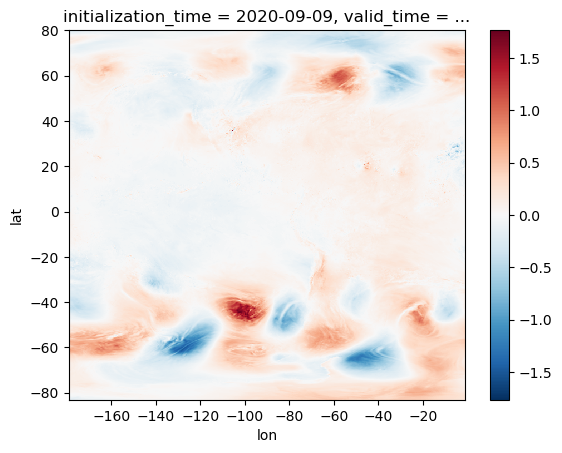

In [17]:
sel = dict(pfull=500, valid_time=case, initialization_time= initialization_time)#, lon=-102, lat=40)

d = (dtend - dt ).sel(sel)
d.plot()
d.max().compute()

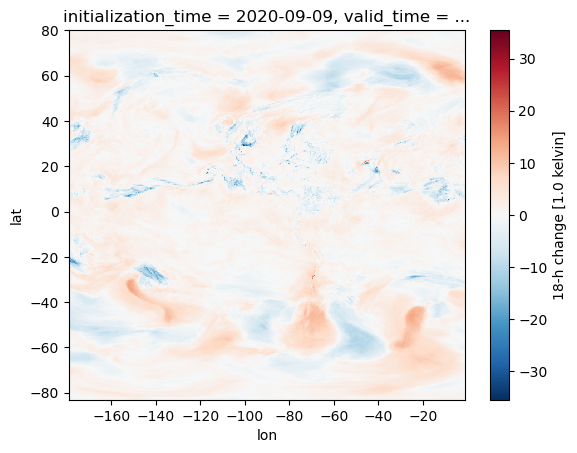

In [18]:
subtract_shift(ds.dt3dt_nonphys, shiftTime).sel(sel).plot()

....xs.t.2020091000.False.png


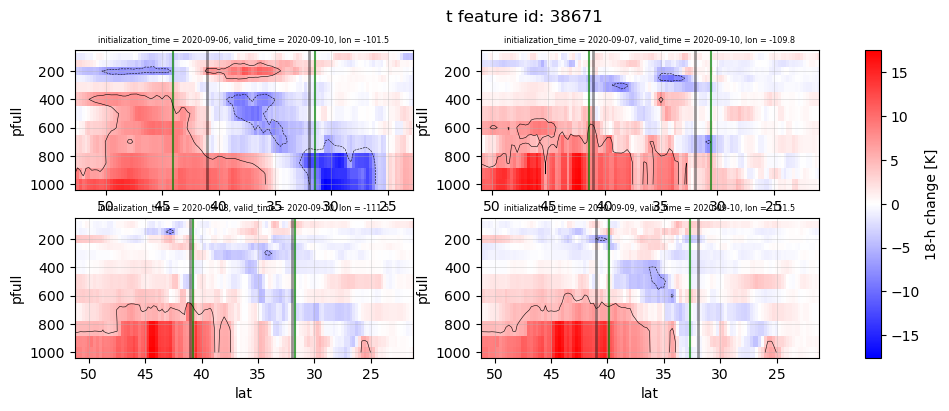

In [19]:
zonal = False

da = subtract_shift(ds[var], shiftTime).sel(valid_time=case)
fig, axes = feature_xs(
    da,
    id,
    "initialization_time",
    zonal=zonal,
)

ofile = f"xs.{var}.{case.strftime('%Y%m%d%H')}.{zonal}.png"
fig.savefig(ofile)
print(ofile)

................xs.t.2020090600.3.False.png


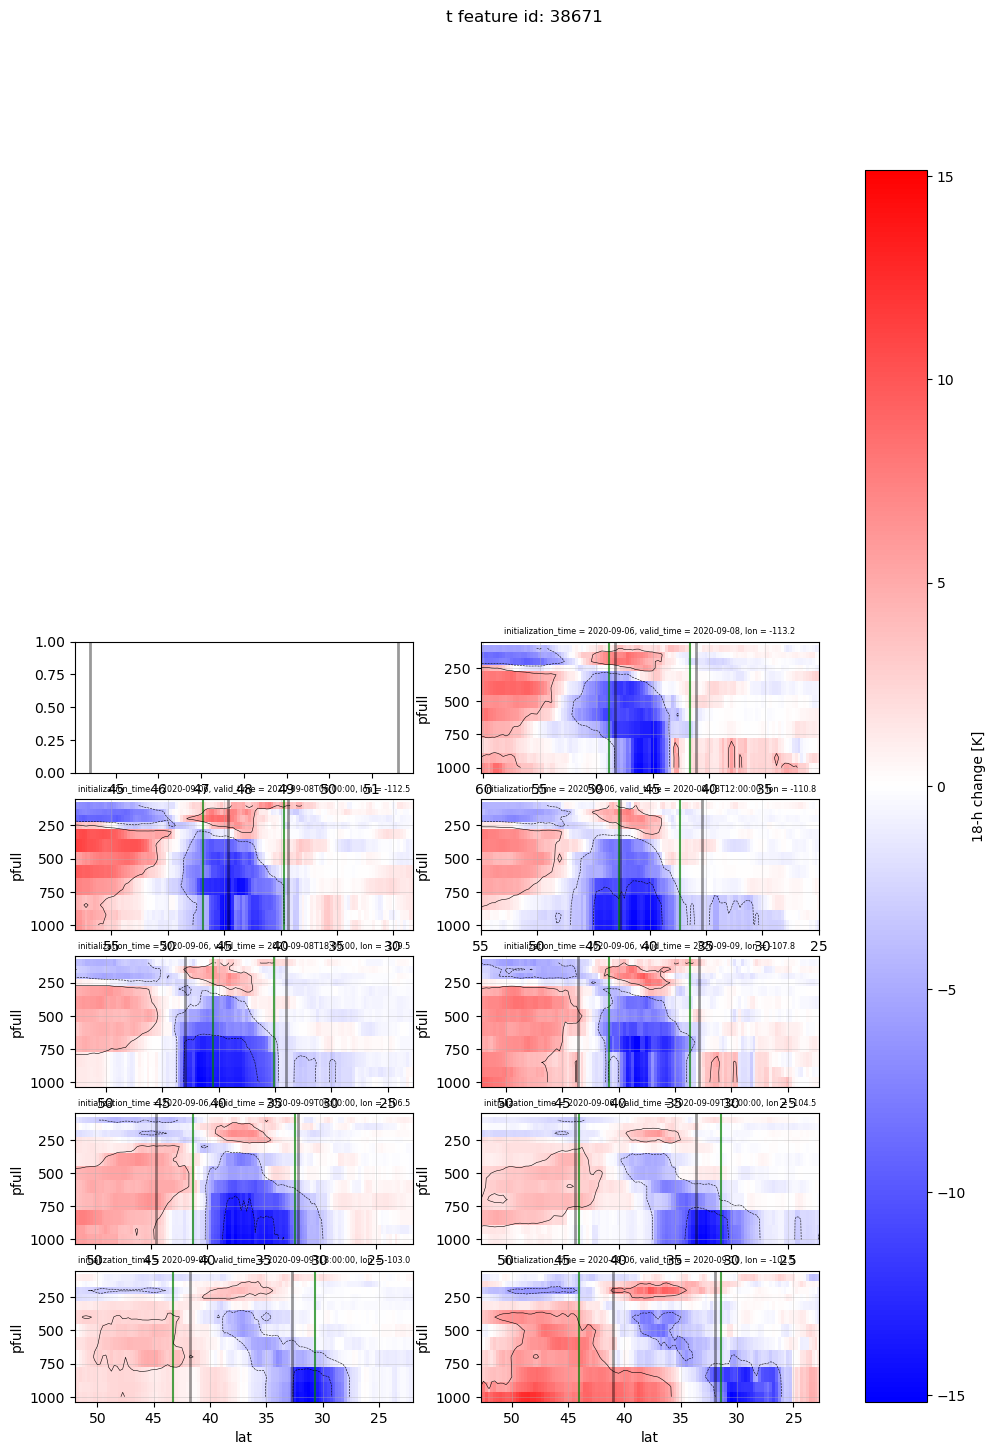

In [20]:
da = subtract_shift(ds[var], shiftTime).sel(
    initialization_time=INITIALIZATION_TIME,
    valid_time=slice(INITIALIZATION_TIME + pd.to_timedelta("6h"), case),
)

fig, axes = feature_xs(
    da,
    id,
    "valid_time",
    zonal=zonal,
)

ofile = f"xs.{var}.{INITIALIZATION_TIME.strftime('%Y%m%d%H')}.{shiftTime}.{zonal}.png"
fig.savefig(ofile)
print(ofile)